## Imports

In [1]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging

import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from bbtoolkit.preprocessing.environment.viz import plot_arrow, plot_polygon
from bbtoolkit.data import Cached
from bbtoolkit.data.configparser import EvalConfigParser
from bbtoolkit.preprocessing.environment import Environment
from bbtoolkit.preprocessing.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.preprocessing.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.preprocessing.environment.utils import env2builder
from bbtoolkit.preprocessing.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.preprocessing.neural_generators import TCGenerator
from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from bbtoolkit.dynamics.callbacks import BaseCallback
from bbtoolkit.preprocessing.environment.fov import FOVManager
from bbtoolkit.preprocessing.environment.fov.ego import EgoManager
from bbtoolkit.math import pol2cart
from bbtoolkit.math.geometry import calculate_polar_distance
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.fov import EgoCallback, EgoSegmentationCallback, FOVCallback, ParietalWindowCallback
from bbtoolkit.dynamics.callbacks.movement import MovementCallback, MovementSchedulerCallback, TrajectoryCallback
from bbtoolkit.movement import MovementManager
from bbtoolkit.dynamics.attention import RhythmicAttention
from bbtoolkit.dynamics.callbacks.attention import AttentionCallback
from bbtoolkit.movement.trajectory import AStarTrajectory
from bbtoolkit.structures.synapses import DirectedTensor
from bbtoolkit.preprocessing.neural_generators import MTLGenerator



logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


### Define Transformation Circuit and Environment

In [2]:


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../data/envs/main_environment.pkl')
env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular,
    n_steps=n_steps
)

mtl_gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, env
)

builder = env2builder(env)
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=[TransparentObjects()]
)

compiler.add_object(
    TexturedPolygon(
        Polygon([
            (-5, -5),
            (-6, -5),
            (-6, -6),
            (-5, -6)
        ]),
        texture=Texture(
            id_=31,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-7, -7),
            (-8, -7),
            (-8, -8),
            (-7, -8)
        ]),
        texture=Texture(
            id_=32,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (2, 2),
            (1, 2),
            (1, 1),
            (2, 1)
        ]),
        texture=Texture(
            id_=33,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-2, 2),
            (-1, 2),
            (-1, 1),
            (-2, 1)
        ]),
        texture=Texture(
            id_=34,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (7, 7),
            (6, 7),
            (6, 6),
            (7, 6)
        ]),
        texture=Texture(
            id_=35,
            color='#ffd200',
            name='main_object'
        )
    )
)

In [3]:
from bbtoolkit.structures.synapses import DirectedTensorGroup, dict2directed_tensor

def connectivity_config2dict(
    config: EvalConfigParser,
    populations: tuple[str, ...] = None,
    ignore: tuple[str, ...] = None
) -> dict[str, dict[str, Any]]:
    """
    Converts EvalConfigParser object into a nested dictionary with specified sections and populations.

    Args:
        config (EvalConfigParser): An instance of EvalConfigParser containing configuration data.
        populations (tuple[str, ..], optional): A tuple of sections to include.
            If None, read all sections except of 'ExternalSources' and 'Hyperparameters'. Defaults to None.
        ignore (tuple[str, ..], optional): A tuple of sections to ignore. 'ExternalSources' and 'Hyperparameters' sections are always ignored. Defaults to None.

    Returns:
        dict[str, dict[str, Any]]: A nested dictionary containing configuration data organized by sections and populations.
    """
    if populations is None:
        populations = tuple(config.sections())

    if ignore is None:
        ignore = {'ExternalSources', 'Hyperparameters'}
    else:
        ignore = set(list(ignore) + ['ExternalSources', 'Hyperparameters'])

    out = {
        config.optionxform(section): {
            population: config.eval(section, population)
            for population in config[section]
        }
        for section in config.sections() if section in populations and section not in ignore
    }
    return out


config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

position = 1, -5
# direction = -np.pi/2
direction = 0
fov_angle = np.pi*.9
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

cache = {'env': compiler.environment, 'tc_gen': tc_gen}
dt = 0.01
n_objects = 5

polar_distance = calculate_polar_distance(tc_gen.r_max)
polar_angle = np.linspace(0, (tc_gen.n_bvc_theta + 1) * tc_gen.polar_ang_res, tc_gen.n_bvc_theta)
polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
pdist, pang = polar_distance, polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [4]:
from bbtoolkit.preprocessing.neural_generators import GCMap

# trunc means not including boundaries themselves
mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_trunc_square.pkl')
tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights.pkl')
hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights.pkl')
pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights_trunc.pkl')
gc_map = GCMap.load('../data/weights/gc_map.pkl')

weights = mtl_weights + tc_weights + hd_weights + pc_weights

n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.h)
n_gc_neurons = len(weights.gc.to.h.T)
n_tc_layers = len(weights.tr.to.pw.T)

In [5]:
from bbtoolkit.structures.synapses import DirectedTensor


tr_projection = DirectedTensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

new_pathways = DirectedTensorGroup(
    DirectedTensor(
        from_='h',
        to='opr',
        weights=np.zeros((n_objects, n_h_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='h',
        weights=np.zeros((n_h_neurons, n_objects))
    ),
    DirectedTensor(
        from_='h',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_h_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='h',
        weights=np.zeros((n_h_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='bvc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opw',
        to='opw',
        weights=np.zeros((n_opw_neurons, n_opw_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='opr',
        weights=np.zeros((n_objects, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='pw',
        weights=np.zeros((n_opw_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='hd',
        weights=np.zeros((n_hd_neurons, n_objects))
    ),
    DirectedTensor(
        from_='bvc',
        to='opr',
        weights=np.zeros((n_objects, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='opr',
        weights=np.zeros((n_objects, n_objects))
    ),
)

In [6]:
weights += tr_projection
weights += new_pathways

weights = weights.operation_with(connectivity, lambda a, b: a - b.get('inhibitory_phi', 0), on_missing_weights='ignore', on_missing_sources='ignore')

In [7]:
from bbtoolkit.math.geometry import points2segments
from bbtoolkit.structures.synapses import NamedTensor, TensorGroup


activity = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('pw', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1)))
)

walls_ego, objects_ego = ego_manager(position, direction)
wall_segments = np.concatenate([points2segments(wall) for wall in walls_ego if wall.size])
ego_input_walls = tc_gen.get_grid_activity(wall_segments)
hd_cue_init = 40*tc_gen.get_hd_activity(np.array([direction]))
hd_cue = np.zeros_like(hd_cue_init)
ohd_cue = hd_cue.copy()
pr_cue = np.zeros((n_pr_neurons, 1))

k_ratio = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('pw', np.expand_dims(40*ego_input_walls, 1)), # FIXME: why 40?
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
)

activity.pw += dt/connectivity.pw.to.pw['tau']*k_ratio.pw

In [8]:
def activity2rate(activity: TensorGroup, connectivity: DirectedTensorGroup) -> TensorGroup:
    """
    Converts the activity of a TensorGroup to firing rates using a sigmoid projection.

    Args:
        activity (TensorGroup): The activity of the neurons.
        connectivity (DirectedTensorGroup): The synaptic connectivity between the neurons.

    Returns:
        TensorGroup: The firing rates of the neurons.
    """
    rates = TensorGroup()
    for key, tensor in activity.data.items():
        key_ = 'pr' if 'pr' in key else key # object identity cells, use same beta and alpha as other PR neurons by definition
        rates.add_tensor(
            NamedTensor(
                key,
                1/(
                    1 + np.exp(-2*connectivity[key_, key_]['beta']*(tensor - connectivity[key_, key_]['alpha']))
                )
            )
        )
    return rates

In [9]:
rates = activity2rate(activity, connectivity)
rates.add_tensor(NamedTensor('gc', np.array([])))
rates.add_tensor(NamedTensor('ip', np.array([])))

In [10]:
from typing import Mapping


class HeadDirectionCallback(BaseCallback):
    def __init__(
        self,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
        no_cue_reset_modes: tuple[str, ...] = ('recall')
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = None
        self.mode = None
        self.no_cue_reset_modes = no_cue_reset_modes

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',
            'tc_gen',
            'movement_params',
            'hd_cue',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]

        cache['hd_cue'] = np.zeros(len(cache['weights'].hd.to.hd))
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):

        if self.mode != self.dynamics_params['mode']:
            if self.dynamics_params['mode'] not in self.no_cue_reset_modes:
                self.total_steps = self.init_timesteps

            self.mode = self.dynamics_params['mode']

        if self.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.total_steps != 0:
            self.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*self.tc_gen.get_hd_activity(np.array([self.movement_params.direction]))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rot_weights = None
        target = self.movement_params.move_target if self.movement_params.move_target is not None else self.movement_params.rotate_target
        if target is not None:
            angle_to_target = math.atan2(
                target[1] - self.movement_params.position[1],
                target[0] - self.movement_params.position[0]
            ) % (2*np.pi)

            diff = angle_to_target - self.movement_params.direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi
            # print(
            #     f'diff: {angle_to_target - self.movement_params.direction : .3f}\n',
            #     f'direction: {self.movement_params.direction : .3f}\n',
            #     f'angle_to_target: {angle_to_target : .3f}\n',
            #     'clockwise' if angle_to_target - self.movement_params.direction < 0 else 'counterclockwise',
            #     'clockwise' if diff < 0 else 'counterclockwise',
            # )

            if diff < 0:
                rot_weights = self.weights.rot.to.rot.T
            elif diff > 0:
                rot_weights = self.weights.rot.to.rot
            elif np.isclose(angle_to_target, self.movement_params.direction):
                rot_weights = None

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        # k_HD = -HDact + HDphi*HD2HDwts * HD_rate + (step<CueDur) * HDCue_init + percep_flag * HDCue
        # + imag_flag * c ... #! IGNORE IMAG PART
        # + Rotphi * CCWturn * Rotwts  * HD_rate ...
        # + Rotphi * CWturn  * Rotwts'' * HD_rate ...
        # + imag_flag * 60 * oPR2HDwts * oPR_rate * oPRHDchange;

        # HDact  = HDact  + dt/HDtau*k_HD;

        # HD_rate    = 1./(1+exp(-2*HDbeta*(HDact-HDalpha)));

        self.k_ratio.hd = -self.activity.hd +\
            (self.connectivity.hd.to.hd['phi']*self.weights.hd.to.hd@self.rates.hd) +\
            self.hd_cue[:, np.newaxis] +\
            (self.connectivity.rot.to.rot['phi']*rot_weights@self.rates.hd)

        if self.dynamics_params['mode'] == 'recall':
            self.k_ratio.hd += self.connectivity.opr.to.hd['phi'] * self.weights.opr.to.hd@self.rates.opr

        self.activity.hd += self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd
        self.rates.hd = 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))

        # HD estimation
        if self.total_steps == 0 and self.dynamics_params['mode'] != 'recall':
            popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
            hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

            self.movement_params.direction = hd_estim



In [11]:
class GCRateCallback(BaseCallback):
    def __init__(self, gc_map: GCMap):
        super().__init__()
        self.gc_map = gc_map.fr

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'movement_params',
            'rates',
            'env'
        ]
        super().set_cache(cache, on_repeat)
        self.x_min = self.env.params.coords[:, 0].min()
        self.x_max = self.env.params.coords[:, 0].max()
        self.y_min = self.env.params.coords[:, 1].min()
        self.y_max = self.env.params.coords[:, 1].max()

    def get_grid_location(self, x: float, y: float) -> tuple[int, int]:
        x = (x - self.x_min)/(self.x_max - self.x_min)
        y = (y - self.y_min)/(self.y_max - self.y_min)
        return int(x*self.gc_map.shape[0]), int(y*self.gc_map.shape[1])

    def on_step_begin(self, step: int):
        self.rates.gc = np.reshape(self.gc_map[*self.get_grid_location(*self.movement_params.position)], (-1, 1))


class PCCallback(BaseCallback):
    def __init__(self, i_comp: float = 0):
        super().__init__()
        # compensatory current to keep PC activty in check
        # was added to have similar amount of active PCs during
        # preplay as during normal sim.
        self.i_comp = i_comp

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['rates'].add_tensor(NamedTensor('i_comp', np.array([self.i_comp]).astype(float)))
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        # k_H = -Hact + ...
        #     Hphi * H2Hwts * H_rate + ...
        #     Pmod * BVC2Hphi * BVC2Hwts * BVC_rate + ...
        #     PR2Hphi * PR2Hwts * PR_rate + ...
        #     OVC2Hphi * OVC2Hwts * OVC_rate +  ...
        #     Imod * oPR2Hphi *  oPR2Hwts * oPR_rate + ... #! IGNORE IMAG PART
        #     GC2PCphi * GC2PCwts * GC_rate + I_comp;

        # Hact     = Hact     + dt/Htau*k_H;

        # H_rate     = 1./(1+exp(-2*Hbeta*(Hact-Halpha)));

        # I_comp   = I_comp + dt/ICtau*(15-sum(H_rate));  % Diff. eq. for compensatory H current (keeping the amounf to active cells approx. constant)

        # also requires bvc rates, pr rates, ovc rates, gc rates and opr rates, updatable weights are opr2h, opr2hd

        self.cache['k_ratio'].h = (
            - self.activity.h
            + self.connectivity.h.to.h['phi']*self.weights.h.to.h@self.rates.h
            + self.connectivity.pr.to.h['phi']*self.weights.pr.to.h@self.rates.pr
            + self.connectivity.ovc.to.h['phi']*self.weights.ovc.to.h@self.rates.ovc
            + self.connectivity.gc.to.h['phi']*self.weights.gc.to.h@self.rates.gc
            + self.rates.i_comp
        )
        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.cache['k_ratio'].h += self.connectivity.bvc.to.h['phi']*self.weights.bvc.to.h@self.rates.bvc
            case 'recall':
                self.cache['k_ratio'].h += self.connectivity.opr.to.h['phi']*self.weights.opr.to.h@self.rates.opr


        self.activity.h += self.dt/self.connectivity.h.to.h['tau']*self.cache['k_ratio'].h
        self.rates.h = 1/(1 + np.exp(-2*self.connectivity.h.to.h['beta']*(self.activity.h - self.connectivity.h.to.h['alpha'])))
        # FIXME: What is the 15 in the equation?
        self.rates.i_comp += self.dt/self.connectivity.ic.to.ic['tau']*(15 - np.sum(self.rates.h))


In [12]:
class BVCCallback(BaseCallback):
    #
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        # % Boundary Vector Cells
        # k_BVC = -BVCact + BVC2BVCwts * BVC_rate + ...           % BVC2BVCwts are currently zero, same for OVC to BVC and vice verse
        #     bleed * Imod * H2BVCphi * H2BVCwts * H_rate + ... #! IGNORE IMAG PART
        #     OVC2BVCphi * OVC2BVCwts * OVC_rate + ...
        #     PR2BVCphi * PR2BVCwts * PR_rate + ...
        #     1/bleed * Pmod * TR2BVCphi * TR2BVCwts * ( TR_rate1 + ...
        #     TR_rate2 + TR_rate3 + TR_rate4 + TR_rate5 + TR_rate6 + TR_rate7 + ...
        #     TR_rate8 + TR_rate9 + TR_rate10 + TR_rate11 + TR_rate12 + TR_rate13 + ...
        #     TR_rate14 + TR_rate15 + TR_rate16 + TR_rate17 + TR_rate18 + TR_rate19 + TR_rate20 );

        # BVCact   = BVCact   + dt/BVCtau*k_BVC;

        # BVC_rate   = 1./(1+exp(-2*BVCbeta*(BVCact-BVCalpha)));

        self.k_ratio.bvc = (
            - self.activity.bvc
            + self.connectivity.bvc.to.bvc['phi'] + self.weights.bvc.to.bvc @ self.rates.bvc
            + self.connectivity.ovc.to.bvc['phi']*self.weights.ovc.to.bvc @ self.rates.ovc
            + self.connectivity.pr.to.bvc['phi']*self.weights.pr.to.bvc @ self.rates.pr
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.bvc += self.connectivity.tr.to.bvc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.tr, axis=0)
            case 'recall':
                self.k_ratio.bvc += self.connectivity.h.to.bvc['phi']*self.weights.h.to.bvc @ self.rates.h


        # self.k_ratio.bvc = -self.activity.bvc +\
        #     self.connectivity.bvc.to.bvc['phi'] + self.weights.bvc.to.bvc @ self.rates.bvc +\
        #     self.connectivity.ovc.to.bvc['phi']*self.weights.ovc.to.bvc @ self.rates.ovc +\
        #     self.connectivity.tr.to.bvc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.tr, axis=0)

        self.activity.bvc += self.dt/self.connectivity.bvc.to.bvc['tau']*self.k_ratio.bvc

        self.rates.bvc = 1/(1 + np.exp(-2*self.connectivity.bvc.to.bvc['beta']*(self.activity.bvc - self.connectivity.bvc.to.bvc['alpha'])))


In [13]:
class OVCCallback(BaseCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        # % Object Vector Cells
        # k_OVC = -OVCact + OVC2OVCphi * OVC2OVCwts * OVC_rate + ...            % OVC to OVC is purely inhibitory
        #     bleed * Imod * H2OVCphi * H2OVCwts * H_rate + ... #! IGNORE IMAG PART
        #     BVC2OVCphi * BVC2OVCwts * BVC_rate + ...
        #     bleed * Imod * oPR2OVCphi * oPR2OVCwts * oPR_rate + ... #! IGNORE IMAG PART
        #     1/bleed * Pmod * TR2OVCphi * TR2BVCwts * ( oTR_rate1 + ...
        #     oTR_rate2 + oTR_rate3 + oTR_rate4 + oTR_rate5 + oTR_rate6 + oTR_rate7 + ...
        #     oTR_rate8 + oTR_rate9 + oTR_rate10 + oTR_rate11 + oTR_rate12 + oTR_rate13 + ...
        #     oTR_rate14 + oTR_rate15 + oTR_rate16 + oTR_rate17 + oTR_rate18 + oTR_rate19 + oTR_rate20 );

        # OVCact   = OVCact   + dt/OVCtau*k_OVC;

        # OVC_rate   = 1./(1+exp(-2*OVCbeta*(OVCact-OVCalpha)));

        self.k_ratio.ovc = (
            - self.activity.ovc
            + self.connectivity.ovc.to.ovc['phi']*self.weights.ovc.to.ovc @ self.rates.ovc
            + self.connectivity.bvc.to.ovc['phi']*self.weights.bvc.to.ovc @ self.rates.bvc
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.ovc += self.connectivity.tr.to.ovc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.otr, axis=0)
            case 'recall':
                self.k_ratio.ovc += (
                    self.connectivity.opr.to.ovc['phi']*self.weights.opr.to.ovc @ self.rates.opr
                    + self.connectivity.h.to.ovc['phi']*self.weights.h.to.ovc @ self.rates.h
                )


        self.activity.ovc += self.dt/self.connectivity.ovc.to.ovc['tau']*self.k_ratio.ovc

        self.rates.ovc = 1/(1 + np.exp(-2*self.connectivity.ovc.to.ovc['beta']*(self.activity.ovc - self.connectivity.ovc.to.ovc['alpha'])))


In [14]:
def get_pr_cue(env: Environment, walls_fov: list[np.ndarray]) -> np.ndarray:
    # 1. get amount of points for each texture id
    counts = dict()
    distances = dict()
    for wall, wall_fov in zip(env.walls, walls_fov):
        if wall.polygon.texture.id_ not in counts:
            counts[wall.polygon.texture.id_] = len(wall_fov)
            d = np.sqrt(np.sum(wall_fov**2, axis=1))
            if d.size:
                distances[wall.polygon.texture.id_] = np.min(d)
            else:
                distances[wall.polygon.texture.id_] = np.inf
        else:
            counts[wall.polygon.texture.id_] += len(wall_fov)
            distances[wall.polygon.texture.id_] = min(distances[wall.polygon.texture.id_], np.min(np.sqrt(np.sum(wall_fov**2, axis=1))))

    distances = dict(sorted(distances.items(), key=lambda x: x[0])) # walls with smallest id first
    counts = dict(sorted(counts.items(), key=lambda x: x[0]))
    # 2. get the pr cue vector which is counts normalized by the distance
    pr_cue = np.array([count/dist for count, dist in zip(counts.values(), distances.values())])

    return pr_cue

In [15]:
class PRCallback(BaseCallback):
    def __init__(self, pr_cue_scale: float = 50):
        super().__init__()
        self.pr_cue_scale = pr_cue_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',
            'env',
            'walls_fov',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        # % Perirhinal Identity Neurons (boundary specific)
        # k_PR = -PRact + PR2PRwts * PR_rate + ...
        #     Imod * H2PRphi * H2PRwts * H_rate + ... #! IGNORE IMAG PART
        #     BVC2PRphi * BVC2PRwts * BVC_rate + (CueDur>step) * PRCue + PRcue_percep;   % PRCue will always be zero except at start

        # PRact   = PRact   + dt/PRtau*k_PR;

        # PR_rate   = 1./(1+exp(-2*PRbeta*(PRact-PRalpha)));

        pr_cue = get_pr_cue(self.env, self.walls_fov)[:, np.newaxis]

        self.pr_cue = self.pr_cue_scale*pr_cue/np.max(pr_cue)

        self.k_ratio.pr = -self.activity.pr +\
            self.connectivity.pr.to.pr['phi']*self.weights.pr.to.pr @ self.rates.pr +\
            self.connectivity.bvc.to.pr['phi']*self.weights.bvc.to.pr @ self.rates.bvc +\
            self.pr_cue

        if self.dynamics_params['mode'] == 'recall':
            self.k_ratio.pr += self.connectivity.h.to.pr['phi']*self.weights.h.to.pr @ self.rates.h

        self.activity.pr += self.dt/self.connectivity.pr.to.pr['tau']*self.k_ratio.pr

        self.rates.pr = 1/(1 + np.exp(-2*self.connectivity.pr.to.pr['beta']*(self.activity.pr - self.connectivity.pr.to.pr['alpha'])))

In [16]:
class oPRCallback(BaseCallback):
    def __init__(self, opr_cue_scale: float = 200):
        super().__init__()
        self.opr_cue = None
        self.opr_cue_scale = opr_cue_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'env',
            'dynamics_params',
            'encoding_params',
            'attention_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.opr_cue = np.zeros((len(self.env.objects), 1))
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        # % Perirhinal Identity Neurons (object specific)
        # k_oPR = -oPRact + (oPR2oPRphi * oPR2oPRwts * oPR_rate + ...
        #     H2oPRphi * H2oPRwts * H_rate + ...
        #     OVC2oPRphi * OVC2oPRwts * OVC_rate + ...
        #     recallobj * oPRCue ).* pseudoadap + percep_flag*200*oPR_drive;   % added actual PR drive, drive 0 during imagery
        #   #! no recall      no pseudo-adaptation  percep=True
        # oPRact   = oPRact   + dt/PRtau*k_oPR;

        # oPR_rate   = 1./(1+exp(-2*PRbeta*(oPRact-PRalpha)));

        self.opr_cue *= 0
        if self.attention_params['attend_to'] is not None and self.dynamics_params['mode'] == 'bottom-up':
            self.opr_cue[self.attention_params['attend_to']] = 1 # currently one oPR neuron per object, however it can depend on texture

        if self.dynamics_params['mode'] == 'recall':
            self.opr_cue[self.encoding_params['object_to_recall']] = 1

        self.k_ratio.opr = (
                -self.activity.opr +
                # self.connectivity.opr.to.opr['phi']*
                self.weights.opr.to.opr*9 @ self.rates.opr +
                self.connectivity.h.to.opr['phi']*self.weights.h.to.opr @ self.rates.h +
                self.connectivity.ovc.to.opr['phi']*self.weights.ovc.to.opr @ self.rates.ovc +
                self.opr_cue_scale*self.opr_cue
        )
        # print(self.connectivity.ovc.to.opr['phi']*self.weights.ovc.to.opr @ self.rates.ovc)

        self.activity.opr  = self.dt/self.connectivity.pr.to.pr['tau']*self.k_ratio.opr

        self.rates.opr = 1/(1 + np.exp(-2*self.connectivity.pr.to.pr['beta']*(self.activity.opr - self.connectivity.pr.to.pr['alpha'])))



In [17]:
class PWCallback(BaseCallback):
    def __init__(self, b_cue_scale: float = 48):
        super().__init__()
        self.b_cue_scale = b_cue_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates',
            'walls_pw'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        # k_PW = -PWact - 100*PW_bath + ...
        # bleed * Imod * TR2PWphi * (TR2PWwts1 * TR_rate1 + ...     #! IGNORE IMAG PART
        # TR2PWwts2*TR_rate2 + TR2PWwts3*TR_rate3 + TR2PWwts4*TR_rate4 + TR2PWwts5*TR_rate5 + ...
        # TR2PWwts6*TR_rate6 + TR2PWwts7*TR_rate7 + TR2PWwts8*TR_rate8 + TR2PWwts9*TR_rate9 + ...
        # TR2PWwts10*TR_rate10 + TR2PWwts11*TR_rate11 + TR2PWwts12*TR_rate12 + TR2PWwts13*TR_rate13 + ...
        # TR2PWwts14*TR_rate14 + TR2PWwts15*TR_rate15 + TR2PWwts16*TR_rate16 + TR2PWwts17*TR_rate17 + ...
        # TR2PWwts18*TR_rate18 + TR2PWwts19*TR_rate19 + TR2PWwts20*TR_rate20) + 1/(min(bleed,2)) ...
        # * BcueScale * EgoCue_percep;

        # PWact    = PWact    + dt/PWtau*k_PW;

        # PW_rate    = 1./(1+exp(-2*PWbeta*(PWact-PWalpha)));

        self.k_ratio.pw = (
            -self.activity.pw
            - self.connectivity.pw.to.pw['inhibitory_phi']
            # + np.sum(np.transpose(self.cache['weights'].tr.to.pw, (2, 0, 1)) @ self.cache['rates'].tr, axis=0)
            # + self.b_cue_scale*np.sum(self.walls_pw, axis=0)[:, np.newaxis]
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.pw += self.b_cue_scale*np.sum(self.walls_pw, axis=0)[:, np.newaxis]
            case 'recall':
                self.k_ratio.pw += self.connectivity.tr.to.pw['phi']*np.sum(np.transpose(self.weights.tr.to.pw, (2, 0, 1)) @ self.rates.tr, axis=0)

        self.activity.pw += self.dt/self.connectivity.pw.to.pw['tau']*self.k_ratio.pw

        self.rates.pw = 1/(1 + np.exp(-2*self.connectivity.pw.to.pw['beta']*(self.activity.pw - self.connectivity.pw.to.pw['alpha'])))


In [18]:
class oPWCallback(BaseCallback):
    def __init__(self, o_cue_scale: float = 40):
        super().__init__()
        self.attn_prev = None
        self.o_cue_scale = o_cue_scale

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates',
            'attention_params',
            'objects_pw'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        # k_oPW = -oPWact - sum(oPW_rate) * oPW_bath + ...
        # bleed * Imod * TR2oPWphi * (TR2PWwts1 * oTR_rate1 + ... #! IGNORE IMAG PART
        # TR2PWwts2*oTR_rate2 + TR2PWwts3*oTR_rate3 + TR2PWwts4*oTR_rate4 + TR2PWwts5*oTR_rate5 + ...
        # TR2PWwts6*oTR_rate6 + TR2PWwts7*oTR_rate7 + TR2PWwts8*oTR_rate8 + TR2PWwts9*oTR_rate9 + ...
        # TR2PWwts10*oTR_rate10 + TR2PWwts11*oTR_rate11 + TR2PWwts12*oTR_rate12 + TR2PWwts13*oTR_rate13 + ...
        # TR2PWwts14*oTR_rate14 + TR2PWwts15*oTR_rate15 + TR2PWwts16*oTR_rate16 + TR2PWwts17*oTR_rate17 + ...
        # TR2PWwts18*oTR_rate18 + TR2PWwts19*oTR_rate19 + TR2PWwts20*oTR_rate20) + 1/(min(bleed,2)) ...
        # * OcueScale * ObjCue_percep + 1 * ObjCue_allocATT; #! AllocATT is 0 for now

        # oPWact   = oPWact   + dt/oPWtau*k_oPW;

        # oPW_rate   = 1./(1+exp(-2*oPWbeta*(oPWact-oPWalpha)));
        objects_pw_cue = self.o_cue_scale*self.objects_pw[self.attention_params['attend_to']][:, np.newaxis] if self.attention_params['attend_to'] is not None else 0


        self.k_ratio.opw = (
            -self.activity.opw
            - np.sum(self.rates.opw) * self.connectivity.opw.to.opw['inhibitory_phi']
            # + np.sum(np.transpose(self.weights.tr.to.pw, (2, 0, 1)) @ self.rates.otr, axis=0)
            # + objects_pw_cue
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.opw += objects_pw_cue
            case 'recall':
                self.k_ratio.opw += self.connectivity.tr.to.opw['phi']*np.sum(np.transpose(self.weights.tr.to.pw, (2, 0, 1)) @ self.rates.otr, axis=0)

        self.activity.opw += self.dt/self.connectivity.opw.to.opw['tau']*self.k_ratio.opw

        self.rates.opw = 1/(1 + np.exp(-2*self.connectivity.opw.to.opw['beta']*(self.activity.opw - self.connectivity.opw.to.opw['alpha'])))

        if self.attn_prev != self.attention_params['attend_to']:
            self.attn_prev = self.attention_params['attend_to']
            logging.debug(f'Switch attention to {self.attention_params["attend_to"]}')

In [19]:
from typing import Mapping


class IPRateCallback(BaseCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'connectivity',
            'rates'
        ]
        super().set_cache(cache, on_repeat)

    def on_step_begin(self, step: int):
        # IPrate = 1./(1+exp(-2*IPbeta*(HD2IPphi*sum(HD_rate)-IPalpha)));

        self.rates.ip = np.array([1/(1 + np.exp(-2*self.connectivity.ip.to.ip['beta']*(self.connectivity.hd.to.ip['phi']*np.sum(self.rates.hd) - self.connectivity.ip.to.ip['alpha'])))])


class TCCallback(BaseCallback):

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        # for i = 1:20
        #     k_TR (i)  = -TRact (i)  - sum(TR_rate (i))  * TR_bath +
        #       HD2TRphi*HD2TRwts(:,:, i) * HD_rate
        #       - IP2TRphi*IPrate +
        #       Imod*BVC2TRphi*BVC2TR + #! IGNORE IMAG PART
        #       1/bleed * Pmod*PW2TRphi*PW2TRwts (i) '*PW_rate;']);
        # end

        # for i = 1:20
        #     eval(['TRact' int2str(i) ' = TRact' int2str(i) ' + dt/TRtau*k_TR' int2str(i) ';']);
        # end

        # for i = 1:20
        #     eval(['TR_rate' int2str(i) ' = 1./(1+exp(-2*TRbeta*(TRact' int2str(i) '-TRalpha)));']);
        # end

        # for i in range(self.rates.tr.shape[0]):
        #     self.k_ratio.tr[i] = -self.activity.tr[i] - np.sum(self.rates.tr[i]) * self.connectivity.tr.to.tr['inhibitory_phi'] +\
        #         self.connectivity.hd.to.tr['phi']*self.weights.hd.to.tr[:, :, i] @ self.rates.hd -\
        #         self.connectivity.ip.to.tr['phi']*self.rates.ip +\
        #         self.connectivity.pw.to.tr['phi']*self.weights.pw.to.tr[:, :, i] @ self.rates.pw

        self.k_ratio.tr = (
            -self.activity.tr
            - np.sum(self.rates.tr, axis=0) * self.connectivity.tr.to.tr['inhibitory_phi']
            + self.connectivity.hd.to.tr['phi']*np.transpose(self.weights.hd.to.tr, (2, 0, 1)) @ self.rates.hd
            - self.connectivity.ip.to.tr['phi']*self.rates.ip
            # + self.connectivity.pw.to.tr['phi']*np.transpose(self.weights.pw.to.tr, (2, 0, 1)) @ self.rates.pw
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.tr += self.connectivity.pw.to.tr['phi']*np.transpose(self.weights.pw.to.tr, (2, 0, 1)) @ self.rates.pw
            case 'recall':
                self.k_ratio.tr += self.connectivity.bvc.to.tr['phi']*self.weights.bvc.to.tr @ self.rates.bvc

        self.activity.tr += self.dt/self.connectivity.tr.to.tr['tau']*self.k_ratio.tr

        self.rates.tr = 1/(1 + np.exp(-2*self.connectivity.tr.to.tr['beta']*(self.activity.tr - self.connectivity.tr.to.tr['alpha'])))

In [20]:
class oTCCallback(BaseCallback):

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        # for i = 1:20
        #     k_oTR (i) '  = -oTRact(i) - sum(oTR_rate (i))  * oTR_bath +
        #         HD2TRphi*HD2TRwts(:,:,i) * HD_rate
        #         - IP2oTRphi*IPrate +
        #         Imod*BVC2TRphi*OVC2TR + #! IGNORE IMAG PART
        #         1/bleed * Pmod*oPW2TRphi*PW2TRwts (i)*oPW_rate;']);
        # end

        # for i = 1:20
        #     eval(['TRact' int2str(i) ' = TRact' int2str(i) ' + dt/TRtau*k_TR' int2str(i) ';']);
        # end

        # for i = 1:20
        #     eval(['TR_rate' int2str(i) ' = 1./(1+exp(-2*TRbeta*(TRact' int2str(i) '-TRalpha)));']);
        # end

        self.k_ratio.otr = (
            - self.activity.otr
            - np.sum(self.rates.otr, axis=0) * self.connectivity.otr.to.otr['inhibitory_phi']
            + self.connectivity.hd.to.tr['phi']*np.transpose(self.cache['weights'].hd.to.tr, (2, 0, 1)) @ self.rates.hd
            - self.connectivity.ip.to.otr['phi']*self.rates.ip
        )

        match self.dynamics_params['mode']:
            case 'bottom-up':
                self.k_ratio.otr += self.connectivity.opw.to.tr['phi']*np.transpose(self.cache['weights'].pw.to.tr, (2, 0, 1)) @ self.rates.opw
            case 'recall':
                self.k_ratio.otr += self.connectivity.bvc.to.tr['phi']*self.weights.bvc.to.tr @ self.rates.ovc


        self.activity.otr += self.dt/self.connectivity.otr.to.otr['tau']*self.k_ratio.otr

        self.rates.otr = 1/(1 + np.exp(-2*self.connectivity.tr.to.tr['beta']*(self.activity.otr - self.connectivity.tr.to.tr['alpha'])))

In [21]:
class ObjectWeightsUpdatingCallback(BaseCallback):
    def __init__(
        self,
        init_steps: int = 10,
        ovc_act_threshold: float = 10
    ):
        super().__init__()
        self.init_steps = init_steps
        self.ovc_act_threshold = ovc_act_threshold

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        if 'encoded_objects' not in cache['encoding_params'] or\
            cache['encoding_params']['encoded_objects'] is None:
            cache['encoding_params'].update(dict(
                encoded_objects=DirectedTensorGroup(
                    DirectedTensor(
                        from_='opr',
                        to='ovc',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='opr',
                        to='h',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='opr',
                        to='hd',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='bvc',
                        to='ovc',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    ),
                    DirectedTensor(
                        from_='ovc',
                        to='h',
                        weights=np.zeros(len(cache['env'].objects)).astype(bool)
                    )
                )
            ))
        self.requires = [
            'activity',
            'weights',
            'encoding_params',
            'attention_params',
            'dynamics_params'
        ]
        super().set_cache(cache, on_repeat)

    def on_step_end(self, step: int):
        if self.dynamics_params['step'] > self.init_steps:
            ovc_act = np.maximum(self.activity.ovc, 0)
            if self.attention_params['attend_to'] is not None and\
                not np.all(ovc_act < self.ovc_act_threshold) and\
                self.cache.attention_params.attention_step > self.cache.attention_params.attention_cycle//3:
                # update weights
                # % OVC2H and H2OVC weights
                # OVC2Hwts_after    = OVC2Hwts;
                # Hact_for_update   = max(Hact,0);                                   % because of negative activations
                # OVCact_for_update = max(OVCact,0);
                # OVCact_for_update(OVCact_for_update<0.05) = 0;                     % ...
                # OVC_x_H_act       = Hact_for_update*OVCact_for_update';
                # OVC_x_H_act       = OVC_x_H_act/max(max(OVC_x_H_act));             % normalize
                # tmp1              = (OVC_x_H_act>0.05);                            % rate threshold, eliminate background 
                # OVC2Hwts_after(tmp1) = OVC2Hwts(tmp1) + OVC_x_H_act(tmp1);
                # OVC2Hwts             = OVC2Hwts_after;
                # H2OVCwts = OVC2Hwts';
                if not self.encoding_params['encoded_objects'].ovc.to.h[self.attention_params['attend_to']]:
                    h_act = np.maximum(self.activity.h, 0)
                    ovc_act[ovc_act < 0.05] = 0
                    ovc_x_h_act = h_act @ ovc_act.T
                    max_act = np.max(ovc_x_h_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    ovc_x_h_act /= max_act
                    tmp1 = ovc_x_h_act > 0.05
                    self.weights.ovc.to.h[tmp1] += ovc_x_h_act[tmp1]
                    self.weights.h.to.ovc = self.weights.ovc.to.h.T
                    self.encoding_params['encoded_objects'].ovc.to.h[self.attention_params['attend_to']] = True
                    logging.debug(f'OVC2H FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

                # % oPR2OVC and OVC2oPR weights
                # OVC2oPRwts_after    = OVC2oPRwts;
                # oPRact_for_update   = max(oPRact,0);                               % because of negative activations
                # OVCact_for_update   = max(OVCact,0);                               % ...
                # OVCact_for_update(OVCact_for_update<0.05) = 0;
                # OVC_x_oPR_act       = oPRact_for_update*OVCact_for_update';
                # OVC_x_oPR_act       = OVC_x_oPR_act/max(max(OVC_x_oPR_act));       % normalize
                # tmp1              = (OVC_x_oPR_act>0.05);                          % rate threshold, eliminate background
                # OVC2oPRwts_after(tmp1) = OVC2oPRwts(tmp1) + OVC_x_oPR_act(tmp1);
                # OVC2oPRwts             = OVC2oPRwts_after;
                # oPR2OVCwts = OVC2oPRwts';
                # FIXME: Wow this structure seems a bit messy
                if not self.encoding_params['encoded_objects'].opr.to.ovc[self.attention_params['attend_to']]:
                    ovc_act = np.maximum(self.activity.ovc, 0)
                    opr_act = np.maximum(self.activity.opr, 0)
                    ovc_act[ovc_act < 0.05] = 0
                    ovc_x_opr_act = opr_act @ ovc_act.T
                    max_act = np.max(ovc_x_opr_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    ovc_x_opr_act = ovc_x_opr_act / max_act
                    tmp1 = ovc_x_opr_act > 0.05
                    self.weights.ovc.to.opr[tmp1] += ovc_x_opr_act[tmp1]
                    self.weights.opr.to.ovc = self.weights.ovc.to.opr.T
                    self.encoding_params['encoded_objects'].opr.to.ovc[self.attention_params['attend_to']] = True
                    logging.debug(f'OPR2OVC FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

                # % oPR2H  weights
                # oPR2Hwts_after    = oPR2Hwts;
                # oPRact_for_update = max(oPRact,0);                                 % because of negative activations
                # Hact_for_update   = max(Hact,0);                                   % ...
                # H_x_oPR_act       = oPRact_for_update*Hact_for_update';
                # H_x_oPR_act       = H_x_oPR_act/max(max(H_x_oPR_act));             % normalize
                # oPR_x_H_act       = H_x_oPR_act';
                # tmp1              = (oPR_x_H_act>0.2);                             % individual thresh
                # oPR2Hwts_after(tmp1) = oPR2Hwts(tmp1) + oPR_x_H_act(tmp1);
                # oPR2Hwts             = oPR2Hwts_after;
                # H2oPRwts = oPR2Hwts';

                if not self.encoding_params['encoded_objects'].opr.to.h[self.attention_params['attend_to']]:
                    h_act = np.maximum(self.activity.h, 0)
                    opr_act = np.maximum(self.activity.opr, 0)
                    h_x_opr_act = opr_act @ h_act.T
                    max_act = np.max(h_x_opr_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    h_x_opr_act = h_x_opr_act / max_act
                    opr_x_h_act = h_x_opr_act.T
                    tmp1 = opr_x_h_act > 0.2
                    self.weights.opr.to.h[tmp1] += opr_x_h_act[tmp1]
                    self.weights.h.to.opr = self.weights.opr.to.h.T
                    self.encoding_params['encoded_objects'].opr.to.h[self.attention_params['attend_to']] = True
                    logging.debug(f'OPR2H FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

                # % oID to HD
                # oPR2HDwts_after   = oPR2HDwts;
                # oPRact_for_update = max(oPRact,0);                                 % because of negative activations
                # HDact_for_update  = max(HDact,0);
                # HD_x_oPR_act      = oPRact_for_update*HDact_for_update';
                # oPR_x_HD_act      = HD_x_oPR_act';
                # oPR_x_HD_act      = oPR_x_HD_act/max(max(oPR_x_HD_act));           % normalize
                # tmp1              = (oPR_x_HD_act>0.2);                            % individual thresh
                # oPR2HDwts_after(tmp1) = oPR2HDwts(tmp1) + oPR_x_HD_act(tmp1);
                # oPR2HDwts             = oPR2HDwts_after;

                if not self.encoding_params['encoded_objects'].opr.to.hd[self.attention_params['attend_to']]:
                    hd_act = np.maximum(self.activity.hd, 0)
                    hd_x_opr_act = opr_act @ hd_act.T
                    opr_x_hd_act = hd_x_opr_act.T
                    max_act = np.max(opr_x_hd_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    opr_x_hd_act = opr_x_hd_act / max_act
                    tmp1 = opr_x_hd_act > 0.2
                    self.weights.opr.to.hd[tmp1] += opr_x_hd_act[tmp1]
                    self.encoding_params['encoded_objects'].opr.to.hd[self.attention_params['attend_to']] = True
                    logging.debug(f'OPR2HD FOR OBJECT {self.attention_params["attend_to"]} UPDATED')


                # % BVC2OVC, could be necessary to support OVC firing in imagery as contentextual input
                # BVC2OVCwts_after    = BVC2OVCwts;
                # OVCact_for_update   = max(OVCact,0);                               % because of negative activations
                # BVCact_for_update   = max(BVCact,0);                               % ...
                # BVCact_for_update(BVCact_for_update<0.05) = 0;
                # BVC_x_OVC_act       = OVCact_for_update*BVCact_for_update';
                # BVC_x_OVC_act       = BVC_x_OVC_act/max(max(BVC_x_OVC_act));       % normalize
                # tmp1              = (BVC_x_OVC_act>0.07);                          % ...
                # BVC2OVCwts_after(tmp1) = BVC2OVCwts(tmp1) + BVC_x_OVC_act(tmp1);
                # BVC2OVCwts             = BVC2OVCwts_after;

                if not self.encoding_params['encoded_objects'].bvc.to.ovc[self.attention_params['attend_to']]:
                    bvc_act = np.maximum(self.activity.bvc, 0)
                    bvc_act[bvc_act < 0.05] = 0
                    ovc_act = np.maximum(self.activity.ovc, 0)
                    bvc_x_ovc_act = ovc_act @ bvc_act.T
                    max_act = np.max(bvc_x_ovc_act)
                    if np.isclose(max_act, 0):
                        max_act = 1
                    bvc_x_ovc_act = bvc_x_ovc_act / max_act
                    tmp1 = bvc_x_ovc_act > 0.07
                    self.weights.bvc.to.ovc[tmp1] += bvc_x_ovc_act[tmp1]
                    self.encoding_params['encoded_objects'].bvc.to.ovc[self.attention_params['attend_to']] = True
                    logging.debug(f'BVC2OVC FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

In [22]:
from typing import Mapping
from bbtoolkit.structures import BaseCallbacksManager, BaseCallback as _BaseCallback, CallbacksCollection


class ArtistCallback(_BaseCallback):
    def on_plot(self):
        ...
    def on_clean(self):
        ...
    def on_copy(self, **kwargs):
        ...
    def on_load(self, **kwargs):
        ...

class PlottingCallback(BaseCallbacksManager, BaseCallback):
    def __init__(self, callbacks: list[ArtistCallback] = None, update_rate: int = 10, fig_kwargs: dict = None, gc_kwargs: dict = None):
        self.update_rate = update_rate
        fig_kwargs = fig_kwargs or dict()
        gc_kwargs = gc_kwargs or dict()
        self.fig_kwargs = fig_kwargs
        self.gc_kwargs = gc_kwargs
        self.callbacks = CallbacksCollection() if callbacks is None else CallbacksCollection(callbacks)
        BaseCallback.__init__(self)

    @property
    def cache(self):
        return self._cache

    @cache.setter
    def cache(self, cache: Mapping):
        self._cache = cache

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = ['fig', 'gc']
        if 'fig' not in cache or not isinstance(cache['fig'], plt.Figure):
            cache['fig'] = plt.figure(**self.fig_kwargs)
            cache['gc'] = GridSpec(**self.gc_kwargs, figure=cache['fig'])
        elif 'fig' in cache and isinstance(cache['fig'], plt.Figure):
            cache['fig'].clf()
        else:
            raise ValueError(f'Invalid cache key for fig: {type(cache["fig"])}')
        super().set_cache(cache, on_repeat=on_repeat)
        self.callbacks.execute('set_cache', cache, on_repeat=on_repeat)
        try:
            self.callbacks.validate()
        except TypeError as e:
            raise TypeError(
                f'Error in {self.__class__.__name__}: Failed to validate callbacks due to: {e}\n'
                f'Note: {self.__class__.__name__} acts as both a BaseCallback and a BaseCallbacksManager.\n'
                f'This means that callbacks within {self.__class__.__name__} are nested within the scope of any external callbacks manager utilizing {self.__class__.__name__}.\n'
                'As a result, these nested callbacks have their own separate visibility scope.\n'
                f'If these nested callbacks depend on cache keys available in the external callbacks manager’s cache, they must be positioned before {self.__class__.__name__} in the execution order.'
            )


    def on_step_end(self, step: int):
        if not step % self.update_rate:
            self.plot()

    def on_simulation_end(self):
        plt.close()

    def plot(self):
        self.callbacks.execute('on_clean')
        self.callbacks.execute('on_plot')
        self.cache['fig'].canvas.draw()
        plt.pause(.00001)

    def on_copy(self, **kwargs):
        self.callbacks.validate()
        self.callbacks.execute('on_copy', **kwargs)

    def on_load(self, **kwargs):
        self.callbacks.validate()
        self.callbacks.execute('on_load', **kwargs)

In [23]:
from typing import Mapping
from shapely.geometry import Polygon, Point


class AloEnvPlotter(ArtistCallback):
    def __init__(self):
        super().__init__()
        self.min_xy = None
        self.max_xy = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['alo_ax'] = cache['fig'].add_subplot(cache['gc'][:4, :4])
        self.requires = [
            'env',
            'walls_fov',
            'objects_fov',
            'alo_ax',
            'attention_params'
        ]
        super().set_cache(cache, on_repeat)
        coords_x, coords_y = self.env.visible_area.boundary.coords.xy
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)
        self.min_xy = (min_train_x, min_train_y)
        self.max_xy = (max_train_x, max_train_y)

    def plot_environment(self):
        """
        Plots the environment, including walls and objects.
        """
        for obj in self.env.objects + self.env.walls:
            plot_polygon(obj.polygon, ax=self.alo_ax, alpha=0.5, linewidth=1)

    def plot_fov(self):
        """
        Plots the agent's field of view, showing visible walls and objects.
        """
        if self.walls_fov:
            for wall, poly in zip(self.walls_fov, self.env.walls):
                self.alo_ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)
        if self.objects_fov:
            for i, (obj, poly) in enumerate(zip(self.objects_fov, self.env.objects)):
                if self.attention_params['attend_to'] is not None and i == self.attention_params['attend_to']:
                    self.alo_ax.plot(obj[:, 0], obj[:, 1], 'o', color='r', markersize=3)
                else:
                    self.alo_ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

    def on_plot(self):
        self.plot_environment()
        self.plot_fov()

    def on_clean(self):
        self.alo_ax.clear()
        self.alo_ax.set_xlim(self.min_xy[0], self.max_xy[0])
        self.alo_ax.set_ylim(self.min_xy[1], self.max_xy[1])


class TargetPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'alo_ax',
            'movement_params'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.movement_params.move_target is not None:
            self.alo_ax.plot(*self.movement_params.move_target, 'rx')
        if self.movement_params.rotate_target is not None:
            self.alo_ax.plot(*self.movement_params.rotate_target, 'co')


class AgentPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'alo_ax',
            'movement_params'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.movement_params.position is not None and self.movement_params.direction is not None:
            self.alo_ax.plot(*self.movement_params.position, 'bo', zorder=1)
            self.alo_ax.arrow(*self.movement_params.position, 0.5 * math.cos(self.movement_params.direction), 0.5 * math.sin(self.movement_params.direction), zorder=1)


class TrajectoryPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'alo_ax',
            'movement_params',
            'movement_schedule',
            'trajectory'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.movement_params.position is not None and \
            (not len(self.trajectory) or
            not (
                self.movement_params.move_target is not None
                and self.movement_params.move_target not in self.trajectory
            )):
            first_points = [self.movement_params.position, self.movement_params.move_target]\
                if self.movement_params.move_target not in self.movement_schedule\
                and self.movement_params.move_target is not None\
                else [self.movement_params.position]
            all_points = first_points + self.movement_schedule
            if len(self.movement_schedule):
                self.alo_ax.plot(
                    self.movement_schedule[-1][0],
                    self.movement_schedule[-1][1],
                    'ro',
                    zorder=-1
                )
            for from_, to in zip(all_points[:-1], all_points[1:]):
                self.alo_ax.plot(*zip(from_, to), 'g-')


class EgoEnvPlotter(ArtistCallback):
    def __init__(self):
        super().__init__()
        self.min_xy = None
        self.max_xy = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['ego_ax'] = cache['fig'].add_subplot(cache['gc'][4:8, :4])
        self.requires = [
            'env',
            'walls_ego_segments',
            'objects_ego_segments',
            'ego_ax',
            'attention_params'
        ]
        super().set_cache(cache, on_repeat)
        coords_x, coords_y = self.env.visible_area.boundary.coords.xy
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)
        # self.min_xy = (min_train_x, -1)
        # self.max_xy = (max_train_x, max_train_y - min_train_y)
        # d = sqrt(a^2 + b^2)
        d = np.sqrt((max_train_x - min_train_x)**2 + (max_train_y - min_train_y)**2)
        middle = (max_train_x + min_train_x)/2, (max_train_y + min_train_y)/2
        self.min_xy = (middle[0] - d, -1)
        self.max_xy = (middle[0] + d, d)


    def plot_ego(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        _ = plot_arrow(np.pi/2, 0, -.75, ax=self.ego_ax)

        if self.walls_ego_segments:
            for segments, poly in zip(self.walls_ego_segments, self.env.walls):
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ego_ax.plot([x_start, x_end], [y_start, y_end], color=poly.polygon.texture.color, linewidth=1)

        if self.objects_ego_segments:
            for i, (segments, poly) in enumerate(zip(self.objects_ego_segments, self.env.objects)):
                color = 'r' if self.attention_params['attend_to'] is not None and i == self.attention_params['attend_to'] else poly.polygon.texture.color
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ego_ax.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=1)

    def on_plot(self):
        self.plot_ego()

    def on_clean(self):
        self.ego_ax.clear()
        self.ego_ax.set_xlim(self.min_xy[0], self.max_xy[0])
        self.ego_ax.set_ylim(self.min_xy[1], self.max_xy[1])


class MouseEventCallback(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = ['fig', 'env', 'movement_params', 'click_params', 'alo_ax']
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    @staticmethod
    def point_outside_bounds(x, y, objects):
        point = Point(x, y)
        is_contained = np.array([
            obj.polygon.contains(point)
            for obj in objects
        ])
        if not np.any(is_contained):
            return False
        else:
            return np.where(is_contained)[0]

    def on_click(self, event: MouseEvent):
        """
        Handles mouse click events on the plot for setting movement and rotation targets.

        Args:
            event (MouseEvent): The mouse click event on the plot.
        """

        if event.inaxes is self.alo_ax:

            self.click_params['xy_data'] = (event.xdata, event.ydata)
            self.click_params['inside_object'] = self.point_outside_bounds(event.xdata, event.ydata, self.env.objects)
            self.click_params['inside_wall'] = self.point_outside_bounds(event.xdata, event.ydata, self.env.walls)

            # Be aware of checking self.click_params['inside_object'], since it can be either false of np.array which may not survive if-else (in the case of np.array([0]))
            if event.button is MouseButton.LEFT and self.click_params['inside_object'] is False and self.click_params['inside_wall'] is False:
                self.alo_ax.plot(event.xdata, event.ydata, 'rx')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.movement_params.move_target = event.xdata, event.ydata
                self.movement_params.rotate_target = None
            elif event.button is MouseButton.RIGHT:
                self.alo_ax.plot(event.xdata, event.ydata, 'co')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.movement_params.rotate_target = event.xdata, event.ydata
                self.movement_params.move_target = None

    def on_copy(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_load(self):
        self.on_copy()


class TimerCallback(BaseCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = ['dynamics_params']
        cache['dynamics_params']['step'] = 0
        super().set_cache(cache, on_repeat)

    def on_step_end(self, step: int):
        self.dynamics_params['step'] += 1


class TimerPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = ['alo_ax', 'dynamics_params']
        super().set_cache(cache, on_repeat)

    def plot(self):
        self.alo_ax.text(-10, 10, f'Time: {(self.dynamics_params["step"])*self.dynamics_params["dt"] : .2f} s')

    def on_plot(self):
        self.plot()


class PWPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['pw_ax'] = cache['fig'].add_subplot(cache['gc'][4:8, 4:8], projection='3d')
        self.requires = [
            'pw_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'x_bvc',
            'y_bvc'
        ]
        polar_distance = calculate_polar_distance(cache['tc_gen'].r_max)
        polar_angle = np.linspace(
            0,
            (cache['tc_gen'].n_bvc_theta + 1) * cache['tc_gen'].polar_ang_res,
            cache['tc_gen'].n_bvc_theta
        )
        polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
        cache['x_bvc'], cache['y_bvc'] = pol2cart(polar_distance, polar_angle)
        super().set_cache(cache, on_repeat)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.pw_ax.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.rates.pw, (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.pw_ax.clear()
        self.pw_ax.view_init(azim=-90, elev=90)
        self.pw_ax.margins(x=0, y=0)
        self.pw_ax.set_axis_off()

class BVCPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['bvc_ax'] = cache['fig'].add_subplot(cache['gc'][:4, 4:8], projection='3d')
        self.requires = [
            'bvc_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'x_bvc',
            'y_bvc'
        ]
        super().set_cache(cache, on_repeat)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.bvc_ax.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.rates.bvc, (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.bvc_ax.clear()
        self.bvc_ax.view_init(azim=0, elev=90)
        self.bvc_ax.margins(x=0, y=0)
        self.bvc_ax.set_axis_off()

class oPWPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['opw_ax'] = cache['fig'].add_subplot(cache['gc'][4:8, 8:], projection='3d')
        self.requires = [
            'opw_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'x_bvc',
            'y_bvc'
        ]
        super().set_cache(cache, on_repeat)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.opw_ax.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.rates.opw, (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.opw_ax.clear()
        self.opw_ax.view_init(azim=-90, elev=90)
        self.opw_ax.margins(x=0, y=0)
        self.opw_ax.set_axis_off()

class OVCPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['ovc_ax'] = cache['fig'].add_subplot(cache['gc'][:4, 8:], projection='3d')
        self.requires = [
            'ovc_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'x_bvc',
            'y_bvc'
        ]
        super().set_cache(cache, on_repeat)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.ovc_ax.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.rates.ovc, (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.ovc_ax.clear()
        self.ovc_ax.view_init(azim=0, elev=90)
        self.ovc_ax.margins(x=0, y=0)
        self.ovc_ax.set_axis_off()


class HDPlotter(ArtistCallback):
    def __init__(self):
        super().__init__()
        self.theta = None
        self.low = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['hd_ax'] = cache['fig'].add_subplot(cache['gc'][8:, 8:], projection='polar')
        self.requires = [
            'hd_ax',
            'rates'
        ]
        super().set_cache(cache, on_repeat)
        theta = np.linspace(0, 2*np.pi, len(self.rates.hd))
        self.theta = np.concatenate([theta, theta[::-1]])
        self.low = np.ones(len(self.rates.hd))/2

    def plot(self):
        high = np.squeeze(self.rates.hd)
        fill_condition = np.where(high >= self.low, high, self.low)
        self.hd_ax.fill(self.theta, np.concatenate([self.low, fill_condition]), color='red', alpha=0.5)


    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.hd_ax.clear()
        self.hd_ax.set_theta_zero_location('E')
        self.hd_ax.set_theta_direction(-1)
        self.hd_ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        self.hd_ax.set_xticklabels(['0°', '270°', '180°', '90°'])
        self.hd_ax.axes.get_yaxis().set_visible(False)


class PCPlotter(ArtistCallback):
    def __init__(self):
        self.shape = None
        super().__init__()

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['gc_ax'] = cache['fig'].add_subplot(cache['gc'][8:, :4])
        self.requires = [
            'gc_ax',
            'rates',
            'env'
        ]
        super().set_cache(cache, on_repeat)
        coords_x, coords_y = self.env.params.coords[:, 0], self.env.params.coords[:, 1]
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)

        self.shape = int((max_train_x - min_train_x)/self.env.params.res), int((max_train_y - min_train_y)/self.env.params.res)

    def plot(self):
        self.gc_ax.imshow(
            np.reshape(self.rates.h, self.shape).T,
            cmap='coolwarm',
            vmin=0, vmax=1,
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.gc_ax.clear()


In [24]:
import time


class DistanceAttention(RhythmicAttention):
    def __init__(self, freq: float, dt: float, n_objects: int, dist_threshold: float):
        super().__init__(freq, dt, n_objects)
        self.dist_threshold = dist_threshold

    @staticmethod
    def mean_dist_to_object(object_: np.ndarray, position: tuple[float, float] = (0, 0)) -> float:
        return np.mean(np.linalg.norm(object_ - position, axis=1))

    def visible_objects(self, objects: list[np.ndarray]) -> list[int]:
        """
        Determines which objects are visible (i.e., have a non-zero size).

        Args:
            objects (list[np.ndarray]): A list of objects represented as numpy arrays.

        Returns:
            list[int]: A list indicating the visibility of each object (True for visible, False for not visible).
        """
        return np.array([
            arr.size > 0
            and
            self.mean_dist_to_object(arr) < self.dist_threshold
            for arr in objects
        ])

class TimerPrinter(BaseCallback):

    def on_step_begin(self, step: int):
        self.time = time.time()

    def on_step_end(self, step):
        print(f'Time: {(self.dynamics_params["step"])*self.dynamics_params["dt"] : .2f} s, runtime: {time.time() - self.time} s')



In [25]:
from matplotlib.backend_bases import KeyEvent
from shapely.geometry import Point

from bbtoolkit.dynamics.callbacks.movement import MovementParameters


class ObjectRecallCallback(ArtistCallback):
    def __init__(self):
        super().__init__()
        self.prev_mode = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = ['encoding_params', 'click_params', 'dynamics_params', 'fig']
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('key_press_event', self.on_press)

    def validate_encoding(self):
        for from_, data_from in self.encoding_params['encoded_objects'].data.items():
                for to, data_to in data_from.items():
                    if not data_to[self.click_params["inside_object"][0]]:
                        raise ValueError(
                            f'Object {self.click_params["inside_object"][0]} is not encoded in {from_}2{to} weights. Recall is not possible.'
                        )

    def on_press(self, event: KeyEvent):

        if self.click_params['inside_object'] is not False and len(self.click_params['inside_object']) > 1:
                    raise ValueError(
                        f'Several objects are selected: {self.click_params["inside_object"]}. '
                        'Likely, these objects are overlapped. Recall is not possible for multiple objects at the same time'
                    )

        if event.key == 'r' and self.click_params['inside_object'] is not False:
            if self.dynamics_params['mode'] != 'recall' or\
                (
                    self.dynamics_params['mode'] == 'recall' and
                    self.click_params['inside_object'][0] != self.encoding_params['object_to_recall']
                ):
                logging.debug(f'Initiate recall for object {self.click_params["inside_object"][0]}')
                self.validate_encoding()
                if self.dynamics_params['mode'] != 'recall':
                    self.prev_mode = self.dynamics_params['mode']
                self.dynamics_params['mode'] = 'recall'
                self.encoding_params['object_to_recall'] = self.click_params['inside_object'][0]
            else:
                logging.debug('Stop recall')
                self.dynamics_params['mode'] = self.prev_mode
                self.encoding_params['object_to_recall'] = None

    def on_copy(self):
        self.fig.canvas.mpl_connect('key_press_event', self.on_press)

    def on_load(self):
        self.on_copy()


class PickedObjectPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = ['alo_ax', 'click_params', 'env']
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.click_params['inside_object'] is not False:
            for obj_ind in self.click_params['inside_object']:
                plot_polygon(self.env.objects[obj_ind].polygon, ax=self.alo_ax, alpha=0.5, linewidth=5, color='b', zorder=-1)


class DistanceAttentionPlotter(ArtistCallback):
    def __init__(self, dist_threshold: float, resolution: int = 100):
        super().__init__()
        self.dist_threshold = dist_threshold
        self.theta = np.linspace(0, 2*np.pi, resolution)
        self.x_r = dist_threshold * np.cos(self.theta)
        self.y_r = dist_threshold * np.sin(self.theta)

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = ['alo_ax', 'ego_ax', 'movement_params', 'env']
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        ego_circle = np.stack([
            self.x_r + self.movement_params.position[0],
            self.y_r + self.movement_params.position[1]
        ], axis=1)

        alo_circle = np.stack([
            self.x_r,
            self.y_r
        ], axis=1)

        self.alo_ax.plot(ego_circle[:, 0], ego_circle[:, 1], color='r', linestyle=':', linewidth=1)
        self.ego_ax.plot(alo_circle[:, 0], alo_circle[:, 1], color='r', linestyle=':', linewidth=1)


class MentalPositionCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.shape = None
        self.x_min, self.x_max, self.y_min, self.y_max = None, None, None, None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'rates',
            'env',
            'weights',
            'dynamics_params',
            'mental_movement_params'
        ]
        cache['mental_movement_params'] = MovementParameters()
        super().set_cache(cache, on_repeat)
        coords_x, coords_y = self.env.params.coords[:, 0], self.env.params.coords[:, 1]
        self.x_min, self.x_max, self.y_min, self.y_max = min(coords_x), max(coords_x), min(coords_y), max(coords_y)

        self.shape = int((self.x_max - self.x_min)/self.env.params.res), int((self.y_max - self.y_min)/self.env.params.res)
        self.hd_vector = np.linspace(0, 2*np.pi, len(self.rates.hd))

    def get_coords_from_grid(self, i: int, j: int) -> tuple[float, float]:
        x = ((i) / self.shape[0]) * (self.x_max - self.x_min) + self.x_min
        # FIXME: y-axis is inverted
        y = ((self.shape[1] - j) / self.shape[1]) * (self.y_max - self.y_min) + self.y_min
        return x, y

    def get_hd_from_rate(self, rate: np.ndarray) -> float:
        return self.hd_vector[np.argmax(rate)]

    def on_step_end(self, step: int):
        if self.dynamics_params['mode'] == 'recall':
            x_grid, y_grid = np.unravel_index(np.argmax(
                self.rates.h
            ), self.shape)
            self.mental_movement_params['position'] = self.get_coords_from_grid(x_grid, y_grid)
            self.mental_movement_params['direction'] = self.get_hd_from_rate(self.rates.hd)
        elif self.dynamics_params['mode'] == 'bottom-up':
            self.mental_movement_params['position'] = None
            self.mental_movement_params['direction'] = None



# class RecallPositionPlotter(ArtistCallback):
#     def __init__(self):
#         super().__init__()
#         self.shape = None
#         self.x_min, self.x_max, self.y_min, self.y_max = None, None, None, None

#     def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
#         self.requires = ['alo_ax', 'rates', 'env', 'weights', 'dynamics_params']
#         super().set_cache(cache, on_repeat)
#         coords_x, coords_y = self.env.params.coords[:, 0], self.env.params.coords[:, 1]
#         self.x_min, self.x_max, self.y_min, self.y_max = min(coords_x), max(coords_x), min(coords_y), max(coords_y)

#         self.shape = int((max_train_x - min_train_x)/self.env.params.res), int((max_train_y - min_train_y)/self.env.params.res)
#         self.hd_vector = np.linspace(0, 2*np.pi, len(self.rates.hd))

#     def get_coords_from_grid(self, i: int, j: int) -> tuple[float, float]:
#         x = ((i) / self.shape[0]) * (self.x_max - self.x_min) + self.x_min
#         # FIXME: y-axis is inverted
#         y = ((self.shape[1] - j) / self.shape[1]) * (self.y_max - self.y_min) + self.y_min
#         return x, y

#     def get_hd_from_rate(self, rate: np.ndarray) -> float:
#         return self.hd_vector[np.argmax(rate)]

#     def on_plot(self):

#         if self.dynamics_params['mode'] == 'recall':
#             x_grid, y_grid = np.unravel_index(np.argmax(
#                 self.rates.h
#             ), self.shape)
#             position = self.get_coords_from_grid(x_grid, y_grid)
#             self.alo_ax.plot(*position, color='#ff80ed', marker='o')
#             direction = self.get_hd_from_rate(self.rates.hd)
#             self.alo_ax.arrow(*position, 0.5 * math.cos(direction), 0.5 * math.sin(direction), zorder=1)

class RecallPositionPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'rates',
            'alo_ax',
            'env',
            'weights',
            'dynamics_params',
            'mental_movement_params'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):

        if self.dynamics_params['mode'] == 'recall':
            if self.mental_movement_params['position'] is not None:
                self.alo_ax.plot(
                    *self.mental_movement_params['position'],
                    color='#ff80ed',
                    marker='o'
                )
                if self.mental_movement_params['direction'] is not None:
                    self.alo_ax.arrow(
                        *self.mental_movement_params['position'],
                        0.5 * math.cos(self.mental_movement_params['direction'] ),
                        0.5 * math.sin(self.mental_movement_params['direction'] ),
                        zorder=1
                    )



In [26]:
class DebugArtist(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = ['fig', 'gc', 'rates', 'activity', 'debug_ax1', 'debug_ax2', 'weights']
        cache['debug_ax1'] = cache['fig'].add_subplot(cache['gc'][8:10, 4:8])
        cache['debug_ax2'] = cache['fig'].add_subplot(cache['gc'][10:, 4:8])
        cache['fig'].tight_layout()
        super().set_cache(cache, on_repeat=on_repeat)

    def on_plot(self):
        self.debug_ax1.imshow(self.weights.ovc.to.opr, aspect='auto', origin='lower')
        # self.debug_ax1.plot(self.activity.opr, 'o')
        self.debug_ax2.plot(self.rates.opr, 'o')
        # self.debug_ax2.plot(self.cache['opr_cue'], 'o')

    def on_clean(self):
        self.debug_ax1.clear()
        self.debug_ax2.clear()
        self.debug_ax2.set_ylim(0, 1)

In [27]:
from abc import ABC
from dataclasses import dataclass, field
from typing import Hashable, Literal

from bbtoolkit.structures import DotDict

@dataclass
class DynamicParameters(DotDict):
    dt: float
    mode: Literal['bottom-up', 'recall']

@dataclass
class EcodingParameters(DotDict):
    encoded_objects: DirectedTensorGroup = field(default_factory=lambda:None)
    object_to_recall: int = field(default_factory=lambda:None)

@dataclass
class ClickParameters(DotDict):
    xy_data: tuple[float, float] = field(default_factory=lambda:None)
    inside_object: bool = field(default_factory=bool)
    inside_wall: bool = field(default_factory=bool)


In [28]:
from dataclasses import dataclass
from bbtoolkit.structures import DotDict

@dataclass
class BBCache(DotDict):
    dynamics_params: DynamicParameters
    encoding_params: EcodingParameters = field(default_factory=lambda:EcodingParameters())
    click_params: ClickParameters = field(default_factory=lambda:ClickParameters())

In [32]:
%matplotlib qt


logging.getLogger('matplotlib').setLevel(logging.WARNING)


dt = .005
# position = (-4, 7.5)
# position = (0, 0)
# position = (0, 0)
# position = (5, -5)
position = (7, -7)
direction = np.pi/2
# direction = -3*np.pi/4

cache = BBCache(
    DynamicParameters(dt, 'bottom-up'),
    EcodingParameters(),
    ClickParameters()
)
cache['env'] = compiler.environment
cache['tc_gen'] = tc_gen
cache['k_ratio'] = k_ratio.copy()

cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['weights'] = weights.copy()
cache['weights'].tr.to.bvc = np.eye(len(weights.tr.to.bvc))
cache['weights'].bvc.to.tr = np.eye(len(weights.tr.to.bvc))
cache['connectivity'] = connectivity.copy()

dynamics = DynamicsManager(
    dt,
    callbacks=[
        TimerCallback(),
        MovementCallback(
            dt,
            MovementManager(
                5,
                math.pi*2,
                position,
                direction
                # np.pi/6
            )
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        ParietalWindowCallback(),
        MovementSchedulerCallback(),
        TrajectoryCallback(
            AStarTrajectory(compiler.environment)
        ),
        AttentionCallback(
            # RhythmicAttention(7, dt, len(compiler.environment.objects))
            DistanceAttention(7, dt, len(compiler.environment.objects), 7.5)
        ),
        HeadDirectionCallback(),
        GCRateCallback(gc_map),
        PCCallback(),
        BVCCallback(),
        OVCCallback(),
        PRCallback(),
        oPRCallback(),
        PWCallback(),
        oPWCallback(),
        IPRateCallback(),
        TCCallback(),
        oTCCallback(),
        ObjectWeightsUpdatingCallback(),
        MentalPositionCallback(),
        PlottingCallback(
            [
                AloEnvPlotter(),
                EgoEnvPlotter(),
                MouseEventCallback(),
                TimerPlotter(),
                TargetPlotter(),
                AgentPlotter(),
                TrajectoryPlotter(),
                PWPlotter(),
                BVCPlotter(),
                oPWPlotter(),
                OVCPlotter(),
                HDPlotter(),
                PCPlotter(),
                DebugArtist(),
                ObjectRecallCallback(),
                PickedObjectPlotter(),
                DistanceAttentionPlotter(7.5),
                RecallPositionPlotter()
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        )
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

2024-05-02 18:00:16 - DEBUG - HD CUE INITIATED
2024-05-02 18:00:32 - DEBUG - HD CUE REMOVED
2024-05-02 18:01:25 - DEBUG - Switch attention to 2
2024-05-02 18:01:39 - DEBUG - OVC2H FOR OBJECT 2 UPDATED
2024-05-02 18:01:39 - DEBUG - OPR2OVC FOR OBJECT 2 UPDATED
2024-05-02 18:01:39 - DEBUG - OPR2H FOR OBJECT 2 UPDATED
2024-05-02 18:01:39 - DEBUG - OPR2HD FOR OBJECT 2 UPDATED
2024-05-02 18:01:39 - DEBUG - BVC2OVC FOR OBJECT 2 UPDATED


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:02:36 - DEBUG - Switch attention to None
2024-05-02 18:03:03 - DEBUG - Switch attention to 2


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:04:06 - DEBUG - Switch attention to 4
2024-05-02 18:04:16 - DEBUG - OVC2H FOR OBJECT 4 UPDATED
2024-05-02 18:04:16 - DEBUG - OPR2OVC FOR OBJECT 4 UPDATED
2024-05-02 18:04:16 - DEBUG - OPR2H FOR OBJECT 4 UPDATED
2024-05-02 18:04:16 - DEBUG - OPR2HD FOR OBJECT 4 UPDATED
2024-05-02 18:04:16 - DEBUG - BVC2OVC FOR OBJECT 4 UPDATED
2024-05-02 18:04:22 - DEBUG - Switch attention to 2
2024-05-02 18:04:37 - DEBUG - Switch attention to 4
2024-05-02 18:04:52 - DEBUG - Switch attention to 2
2024-05-02 18:05:07 - DEBUG - Switch attention to 4
2024-05-02 18:05:22 - DEBUG - Switch attention to 2
2024-05-02 18:05:25 - DEBUG - Initiate recall for object 2
2024-05-02 18:05:37 - DEBUG - Switch attention to 4


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:05:50 - DEBUG - Initiate recall for object 4
2024-05-02 18:05:53 - DEBUG - Switch attention to 2
2024-05-02 18:06:08 - DEBUG - Switch attention to 4
2024-05-02 18:06:23 - DEBUG - Switch attention to 2
2024-05-02 18:06:38 - DEBUG - Switch attention to 4
2024-05-02 18:06:38 - DEBUG - Stop recall
2024-05-02 18:06:38 - DEBUG - HD CUE INITIATED
2024-05-02 18:06:53 - DEBUG - Switch attention to 2
2024-05-02 18:06:55 - DEBUG - HD CUE REMOVED
2024-05-02 18:07:09 - DEBUG - Switch attention to 4
2024-05-02 18:07:23 - DEBUG - Switch attention to 3


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:07:34 - DEBUG - OVC2H FOR OBJECT 3 UPDATED
2024-05-02 18:07:34 - DEBUG - OPR2OVC FOR OBJECT 3 UPDATED
2024-05-02 18:07:34 - DEBUG - OPR2H FOR OBJECT 3 UPDATED
2024-05-02 18:07:34 - DEBUG - OPR2HD FOR OBJECT 3 UPDATED
2024-05-02 18:07:34 - DEBUG - BVC2OVC FOR OBJECT 3 UPDATED
2024-05-02 18:07:39 - DEBUG - Switch attention to 2
2024-05-02 18:07:54 - DEBUG - Switch attention to 4
2024-05-02 18:08:09 - DEBUG - Switch attention to 3
2024-05-02 18:08:25 - DEBUG - Switch attention to 2
2024-05-02 18:08:40 - DEBUG - Switch attention to 3
2024-05-02 18:08:56 - DEBUG - Switch attention to 2
2024-05-02 18:09:11 - DEBUG - Switch attention to 3


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:10:26 - DEBUG - Switch attention to None


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:13:11 - DEBUG - Switch attention to 0
2024-05-02 18:13:17 - DEBUG - OVC2H FOR OBJECT 0 UPDATED
2024-05-02 18:13:17 - DEBUG - OPR2OVC FOR OBJECT 0 UPDATED
2024-05-02 18:13:17 - DEBUG - OPR2H FOR OBJECT 0 UPDATED
2024-05-02 18:13:17 - DEBUG - OPR2HD FOR OBJECT 0 UPDATED
2024-05-02 18:13:17 - DEBUG - BVC2OVC FOR OBJECT 0 UPDATED
2024-05-02 18:13:38 - DEBUG - Switch attention to 3
2024-05-02 18:13:53 - DEBUG - Switch attention to 2
2024-05-02 18:14:09 - DEBUG - Switch attention to 3
2024-05-02 18:14:25 - DEBUG - Switch attention to 2
2024-05-02 18:14:41 - DEBUG - Switch attention to 0


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:14:56 - DEBUG - Switch attention to 3
2024-05-02 18:15:11 - DEBUG - Switch attention to 2
2024-05-02 18:16:26 - DEBUG - Switch attention to None


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:16:40 - DEBUG - Switch attention to 4
2024-05-02 18:16:56 - DEBUG - Switch attention to None
2024-05-02 18:17:01 - DEBUG - Switch attention to 4
2024-05-02 18:17:53 - DEBUG - Switch attention to None


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:22:45 - DEBUG - Switch attention to 0


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:23:31 - DEBUG - Switch attention to 1
2024-05-02 18:23:37 - DEBUG - OVC2H FOR OBJECT 1 UPDATED
2024-05-02 18:23:37 - DEBUG - OPR2OVC FOR OBJECT 1 UPDATED
2024-05-02 18:23:37 - DEBUG - OPR2H FOR OBJECT 1 UPDATED
2024-05-02 18:23:37 - DEBUG - OPR2HD FOR OBJECT 1 UPDATED
2024-05-02 18:23:37 - DEBUG - BVC2OVC FOR OBJECT 1 UPDATED
2024-05-02 18:23:46 - DEBUG - Switch attention to 0
2024-05-02 18:24:01 - DEBUG - Switch attention to 1
2024-05-02 18:24:16 - DEBUG - Switch attention to 0
2024-05-02 18:24:31 - DEBUG - Switch attention to 1
2024-05-02 18:24:46 - DEBUG - Switch attention to 0
2024-05-02 18:25:01 - DEBUG - Switch attention to 1


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:25:16 - DEBUG - Switch attention to 0
2024-05-02 18:25:31 - DEBUG - Switch attention to 1
2024-05-02 18:25:45 - DEBUG - Switch attention to 0
2024-05-02 18:26:01 - DEBUG - Switch attention to 1
2024-05-02 18:26:16 - DEBUG - Switch attention to 3
2024-05-02 18:26:32 - DEBUG - Switch attention to 2
2024-05-02 18:26:48 - DEBUG - Switch attention to 3


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:27:03 - DEBUG - Switch attention to 2
2024-05-02 18:27:18 - DEBUG - Switch attention to 3
2024-05-02 18:27:33 - DEBUG - Switch attention to 2
2024-05-02 18:27:48 - DEBUG - Switch attention to 3
2024-05-02 18:28:04 - DEBUG - Switch attention to 2
2024-05-02 18:28:18 - DEBUG - Switch attention to 3


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-02 18:28:48 - DEBUG - Switch attention to None


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


KeyboardInterrupt: 

In [ ]:
for _ in dynamics(True):
    print('out: ', _)

KeyboardInterrupt: 

In [33]:
dynamics.save('../data/dynamics.pkl')

In [35]:
%matplotlib qt
dynamics_pretrained = DynamicsManager.load('../data/dynamics.pkl')
for _ in dynamics_pretrained(True):
    print('out: ', _)

out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-03 10:12:18 - DEBUG - Initiate recall for object 0
2024-05-03 10:13:04 - DEBUG - Initiate recall for object 2


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-03 10:13:20 - DEBUG - Initiate recall for object 4
2024-05-03 10:13:36 - DEBUG - Initiate recall for object 1
2024-05-03 10:14:33 - DEBUG - Stop recall
2024-05-03 10:14:33 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-03 10:14:47 - DEBUG - HD CUE REMOVED
2024-05-03 10:15:33 - DEBUG - Switch attention to 3


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


2024-05-03 10:26:20 - DEBUG - Initiate recall for object 0


out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
out:  (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)


KeyboardInterrupt: 

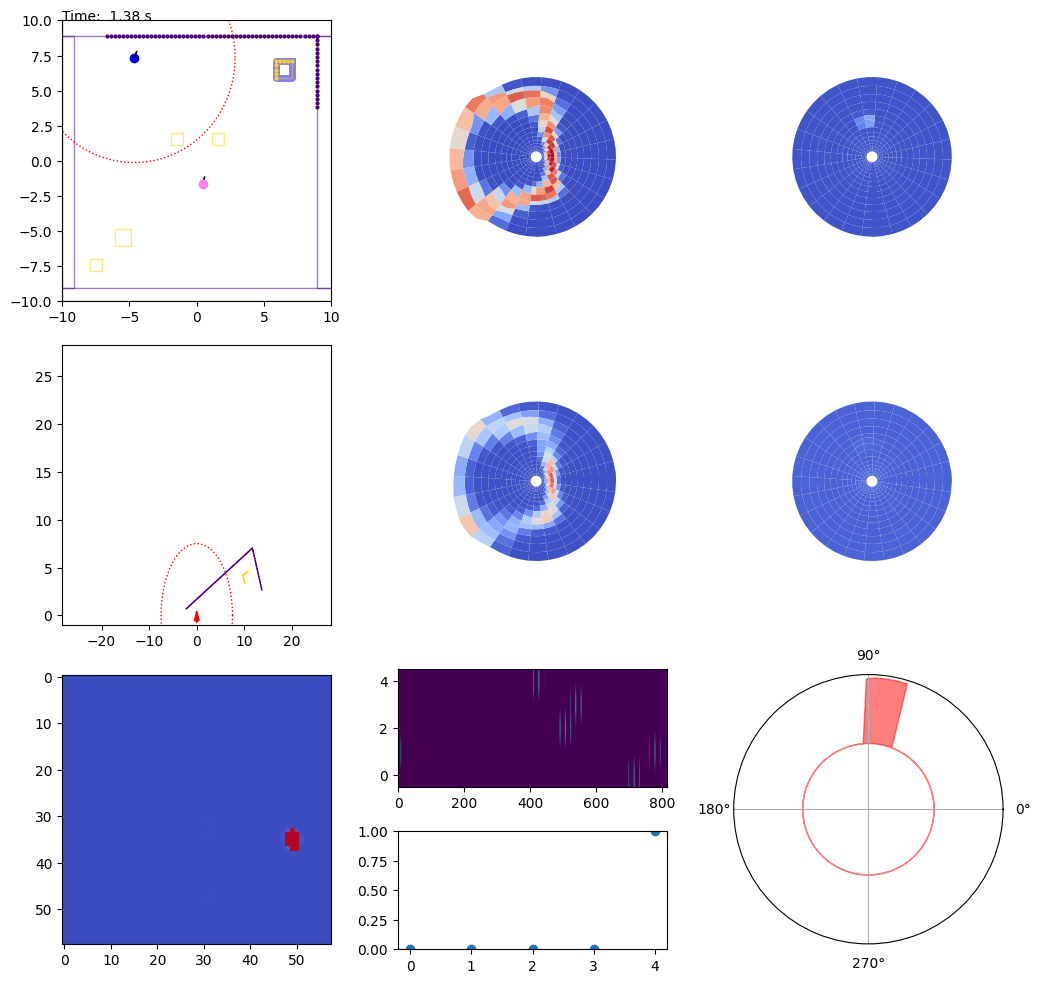

In [ ]:
%matplotlib inline
plt.show()

In [ ]:
dynamics_pretrained.cache.mental_movement_params

MovementParameters(position=(0.49589041095893016, -1.6493150684931317), direction=1.3962634015954636, move_target=None, rotate_target=None)

In [ ]:
dynamics_pretrained.callbacks[-2].shape

(73, 73)